# 3 - Linear Prediction

In [1]:
include("./JuliaImpl/SSP.jl");
include("./JuliaImpl/Sheet1.jl");
include("./JuliaImpl/Sheet2.jl");
include("./JuliaImpl/Sheet3.jl");
using Plots
using DSP
using SSP
pyplot()

Plots.PyPlotBackend()

## 1) Loading the speech file

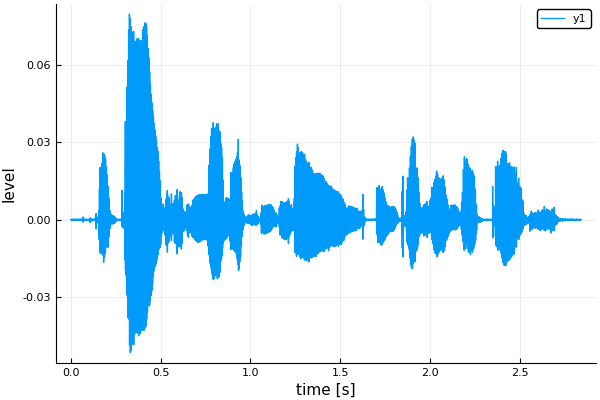

In [2]:
speech1 = loadAudio("./Exercise3/Audio/speech1.wav");
plotAudio(speech1)

## 2) Selecting segments from the voice signal

For our own convenience we've written a function `between(audio,t0,t1)` which cuts out a segment of the `audio` between `t0` and `t1`.

```julia
function between(audio::Audio, t0::Float64, t1::Float64)
    s0 = floor(Int, t0 * samplingRate(audio))
    s1 = floor(Int, t1 * samplingRate(audio))
    t0_ = s0 / samplingRate(audio)
    Audio(audio.samples[s0:s1,:], samplingRate(audio), t0_)
end
```

With this we select a voiced and an unvoiced segment.

In [3]:
voiced = Sheet3.between(speech1, 0.4, 0.4+32e-3);
unvoiced = Sheet3.between(speech1, 0.53, 0.53+32e-3);

## 3) LPC coefficients

The LPC estimator is easily implemented:

```julia
# ./JuliaImpl/Sheet3.jl
function lpc(signal :: Vector{Float64}; m=12::Int)
    n = length(signal)
    ϕ = xcorr(signal, signal)[n:n+m-1]
    y = xcorr(signal, signal)[n+1:n+m]
    M = toeplitz(ϕ)
    a = -M \ y
    a
end
```



Let's compute some coefficients:

In [4]:
a_voiced = Sheet3.lpc(voiced);
a_unvoiced = Sheet3.lpc(unvoiced);
display(hcat(vcat("voiced", a_voiced),
             vcat("unvoiced", a_unvoiced)))

13×2 Array{Any,2}:
   "voiced"    "unvoiced"
 -1.75677     0.902488   
  0.720071   -0.0133435  
  0.290885    0.0953318  
 -0.0395323   0.284966   
 -0.104635    0.0147807  
 -0.0504448   0.105339   
  0.0537225   0.0267678  
  0.0598151   0.121963   
  0.0414651   0.181017   
 -0.0407347  -0.0104484  
 -0.146877   -0.0142639  
  0.175928    0.0772323  

For convenience we implement versions of `lpc` which work not only on raw samples but on `Audio` and `FramedAudio`:

```julia
# ./JuliaImpl/Sheet3.jl
function lpc(audio::Audio; m=12::Int, track=1::Int)
    lpc(audio.samples[:,track], m=m)
end
```

```julia
# ./JuliaImpl/Sheet3.jl
function lpc(faudio::FramedAudio; m=12::Int, track=1::Int)
    as = zeros(numFrames(faudio),m)
    for i in 1:numFrames(faudio)
        as[i,:] = lpc(faudio.frames[:,track,i])
    end
    as
end
```

For `FramedAudio` the output of `lpc` is a $F\times m$-matrix where $F$ is the number of frames and $m$ is the number of coefficients we want to produce.


## 4) Frequency Response

In order to compute the frequency response we have to evaluate a complex rational function.
We proceed in two steps:
1. we compute a polynomial from coefficients
2. we compute the ratio of polynomials from coefficients

```julia
# ./JuliaImpl/Sheet3.jl
function polynomial(coeffs::Vector{Float64}, z::Complex{Float64})
    sum(map(i -> coeffs[i]*z^(i-1), 1:length(coeffs)))
end

# ./JuliaImpl/Sheet3.jl
function freqz(b::Vector{Float64}, a::Vector{Float64}, n::Int; whole=false::Bool)
    f = z -> polynomial(b, 1/z) / polynomial(a, 1/z)
    I = linspace(0, whole ? 2*pi : pi, n+1)[1:n]
    f.(exp.(1.0im * I))
end
```

Alternatively you can use the `DSP` module and write `DSP.freqz(b, a, linspace(0,pi,n+1)[1:n])` for the same results.

In order to plot the frequency response we want the $x$-axis labels to be meaningful: They should tell us the frequency of the corresponding Fourier coefficient.

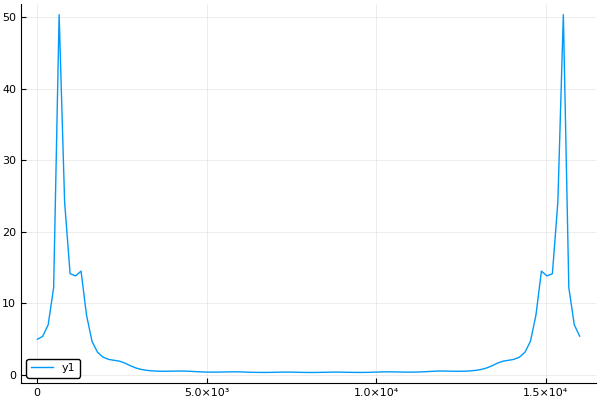

In [5]:
plot(linspace(0, samplingRate(voiced), 100),
    abs.(Sheet3.freqz([1.], vcat(1,a_voiced), 100, whole=true)))

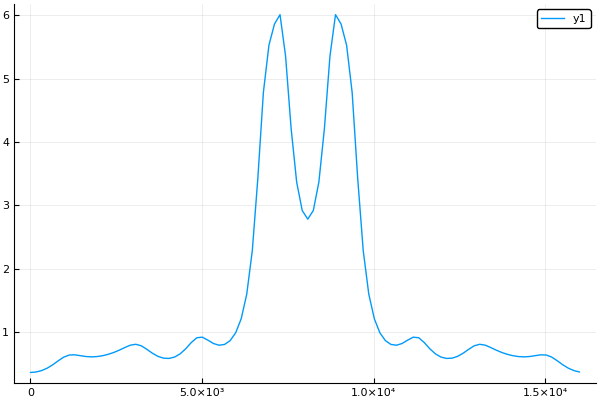

In [6]:
plot(linspace(0, samplingRate(unvoiced), 100),
    abs.(Sheet3.freqz([1.], vcat(1,a_unvoiced), 100, whole=true)))

_Q: Why do we use `vcat(1,a)` as input argument for freqz?_

The LPC estimator only gives us the coefficients $a_1,...,a_{m}$ and we have to supply $a_0 = 1$ manually.

## 5) Plotting the FFT and the FrequencyResponse

Here we plot the (estimated) frequency response as well as the signal into one plot.
First for the voiced segment:

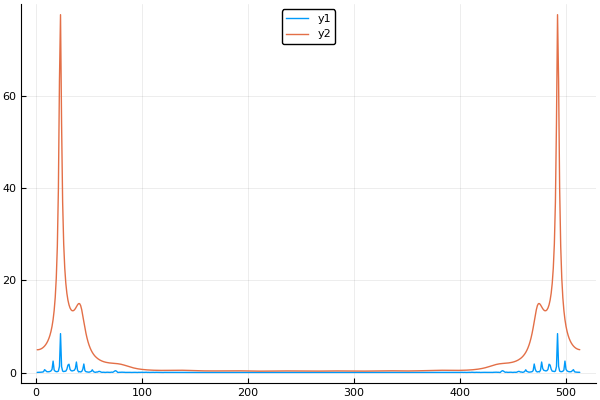

In [7]:
s_voiced = fft(voiced.samples[:,1])
shat_voiced = Sheet3.freqz([1.],vcat(1.,a_voiced),
    numSamples(voiced),whole=true)

plot([abs.(s_voiced), abs.(shat_voiced)])

And then for the unvoiced segment:

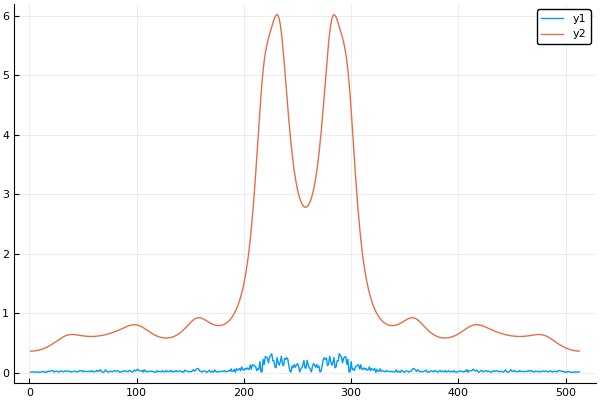

In [8]:
s_unvoiced = fft(unvoiced.samples[:,1])
shat_unvoiced = Sheet3.freqz([1.],vcat(1.,a_unvoiced),
    numSamples(unvoiced),whole=true)

plot([abs.(s_unvoiced), abs.(shat_unvoiced)])

## 6) Computing the Residual Signal

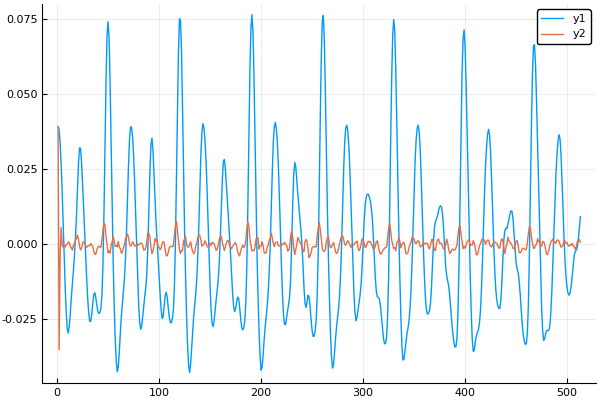

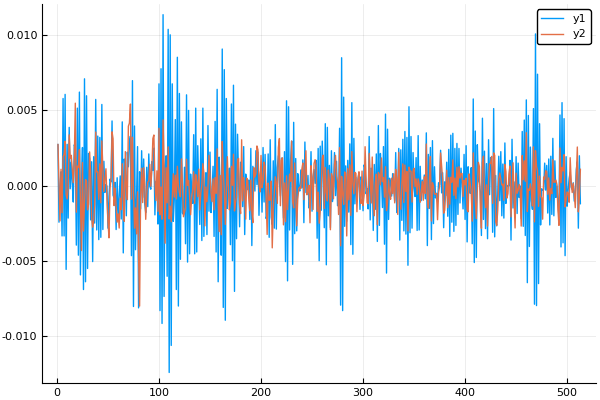

In [9]:
function my_analysis(audio::Audio;m=12)
    s = audio.samples[:,1]
    a = Sheet3.lpc(s,m=m)
    e = filt(vcat(1.,a),[1.],s)
    # play the residual sound (multiple times) :)
    playAudio(loadAudio(vcat(e,e,e,e,e,e),samplingRate(audio)))
    plot([s,e])
end

display(my_analysis(voiced,m=4))
display(my_analysis(unvoiced,m=4))

We use the LPC coefficients to approximate the filter in the source-filter model.

The voiced excitation signal $e$ is filtered using the polynomial quotient filter given by our ARMA-model derived least mean square distance approximation.
To regain the excitation signal, we only need to filter with the inverse polynomial quotient, which the swap of the $a$ and $b$ coefficient does.

Now the excitation signal is approximated by the residual signal, as the linear predictor tries to push the residual signal $s-\hat{s}$ close to the excitation signal $e$ (up to the multiplicative factor $b_0$).
Therefore our filtering procedure above approximately computes the excitation signal (up to $b_0$).


## 7) Balancing Levels


`H` is a very crude approximation for the spectral envelope of `S` which only cares about the peaks in the spectral envelope.
So we cannot even hope for `H` and `S` to be similar in amplitude.

However, if we set $b_0 \approx 0.038$, we get a much better match:



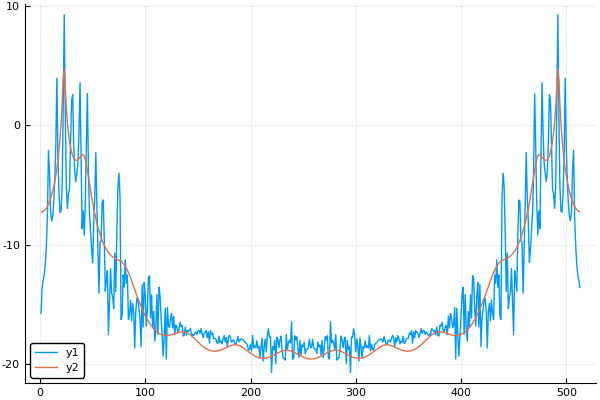

In [10]:
s_voiced = fft(voiced.samples[:,1])
shat_voiced = Sheet3.freqz([0.038],vcat(1.,a_voiced),
    numSamples(voiced),whole=true)
dB = x -> 10*log10.(x)
plot([dB(abs.(s_voiced)), dB(abs.(shat_voiced))])

## 8) Order of the Predictor

We observed that a larger $M$ minimizes the residual signal. This is intuitive, as larger $M$ allow for more degrees of freedom -- remember that $M$ is the degree of the denominator polynomial used for computing the frequency response.

On the other hand there aren't substantial improvements for $M$ going from $2$ to, say, $20$.

## 9) Spectral Tilt

We compute the pre-emphasised signal.


```julia
# ./JuliaImpl/Sheet3.jl
function my_preemphasis(audio::Audio; alpha=0.95)
    s = audio.samples[:,1]
    y = zeros(length(s)-1)
    for i in 1:length(y)
        y[i] = s[i+1] - alpha*s[i]
    end
    loadAudio(y,samplingRate(audio))
end
```

After computing the pre-emphasised signals we again apply our previous analysis and get the residual signal.

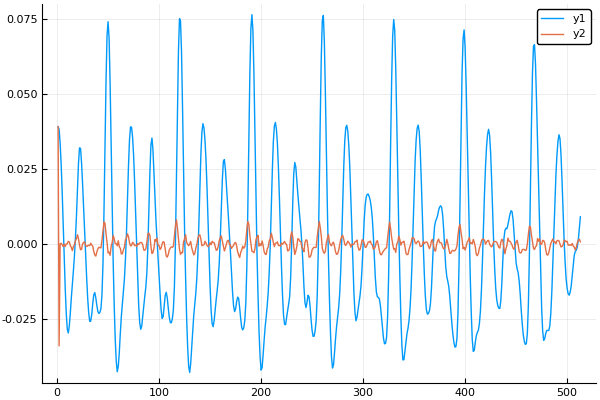

In [14]:
speech1_pre = Sheet3.my_preemphasis(speech1)
voiced_pre = Sheet3.between(speech1, 0.4, 0.4+32e-3);
unvoiced_pre = Sheet3.between(speech1, 0.53, 0.53+32e-3);

my_analysis(voiced_pre,m=2)

In the time domain, the effect of the pre-emphasis is barely visible.

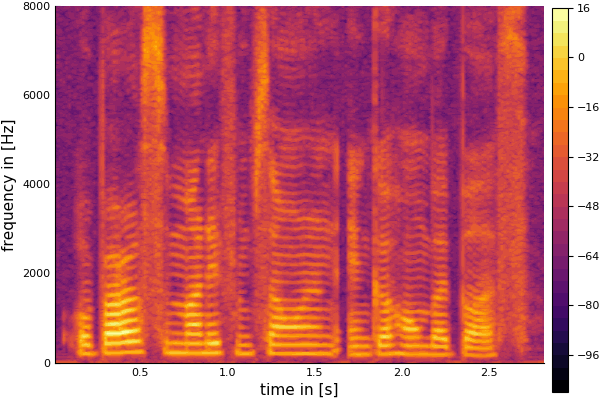

In [12]:
Sheet2.my_spectrogram(Sheet2.my_stft(Sheet2.applyWindow(Sheet1.my_windowing(speech1))))

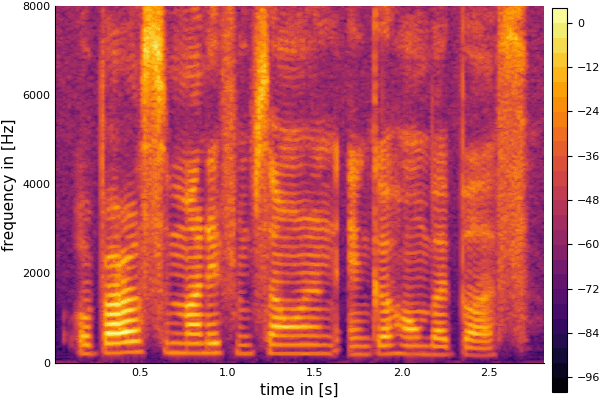

In [15]:
Sheet2.my_spectrogram(Sheet2.my_stft(Sheet2.applyWindow(Sheet1.my_windowing(speech1_pre))))

However, if we look at the spectra, we see that the "ripples" are slightly more marked in the pre-emphasised signal.
Also the ripples of the lower frequencies are more defined too.